This notebook contains code that will train a convolutional nueral network on SVHN dataset.
Tensorflow is used for this project.
To get the idea of the project, first lets see the data that we are taking into consideration.

Dataset is taken from [SVHN stanford](http://ufldl.stanford.edu/housenumbers/) 

NOTE: This dataset is in MNIST-like **character** level ground truth.


![Example images](32x32eg.png)

The data is available in 3 .mat files **train_32x32.mat**, **test_32x32.mat** , **extra_32x32.mat**

All digits have been resized to a fixed resolution of 32-by-32 pixels.

Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 


In [1]:
"""Import all modules"""
%matplotlib inline
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
from IPython.display import display, Image
from scipy import ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import tarfile
import h5py
import scipy.io
from collections import Counter

In [2]:
"""Download the train,test and extra dataset """
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    print (statinfo.st_size)
    return filename

train_filename = maybe_download('train_32x32.mat')
test_filename  = maybe_download('test_32x32.mat')
extra_filename = maybe_download('extra_32x32.mat')

print("Success")

182040794
64275384
1329278602
Success


Now we have to load the .mat files which we do using scipy.io.loadmat function

In [3]:
def loadMatFiles(fileName):
    matData = scipy.io.loadmat(fileName)
    return matData['X'],matData['y']

train_imgData,train_labelData = loadMatFiles(train_filename)
test_imgData,test_labelData   = loadMatFiles(test_filename)
#extra_imgData, extra_labelData= loadMatFiles(extra_filename)

print ("Train image Shape ",train_imgData.shape)
print ("Test image shape ",test_imgData.shape)
#print ("extra image shape",extra_imgData.shape)

print ("Train label shape",train_labelData.shape)
print ("Test label shape",test_labelData.shape)
#print ("Extra label shape",extra_labelData.shape)

Train image Shape  (32, 32, 3, 73257)
Test image shape  (32, 32, 3, 26032)
Train label shape (73257, 1)
Test label shape (26032, 1)


To see the distribution of class labels, lets see the bar graph of the data

[1]


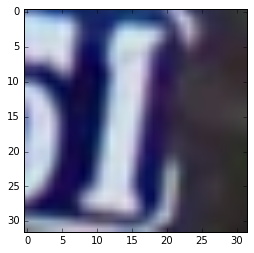

In [4]:
print (train_labelData[89])
plt.imshow(np.abs(train_imgData[:,:,:,89]))
plt.show()

Accuracy function is defined here

In [5]:
"""Define accuracy function"""
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

print("Success")

Success


For Data to be fed into CNN, the data needs to be reformatted. The data shape for images is to be (<NumberOfImages>,32,32,3) and data shape for labels must be (<NumberOfImages>,10).
This means that all labels must be **one-hot encoded**.
Also, for converting the image data , we will iterate over the *_imgData and append each row to a list and then convert the entire list to an array

In [6]:
def createOneHotEncoding(classLabels):
    YClassLabels = []
    for label in classLabels:
        T = np.zeros(10)
        if label < 10:
            T[label] = 1
        else:
            T[0] = 1
        YClassLabels.append(T)
    return np.asarray(YClassLabels)

def formatDataForConvNet(imageData,classLabels):
    count   = imageData.shape[3]
    data    = []
    for i in xrange(count):
        im = imageData[:,:,:,i]
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        data.append(im)
    imageData   = np.asarray(data)
    classLabels = createOneHotEncoding(classLabels)
    return imageData, classLabels

def formatAllData(imageData,classLabels):
    imageT = np.array(imageData,copy=True)
    classT = np.array(classLabels,copy=True)
    imageT, classT = formatDataForConvNet(imageT,classT)
    return imageT,classT
    
train_imgT, train_labelT = formatAllData(train_imgData,train_labelData)
test_imgT, test_labelT   = formatAllData(test_imgData,test_labelData)
print ("train data shapes =>",train_imgT.shape, train_labelT.shape)
print ("test data shapes  =>",test_imgT.shape,test_labelT.shape)

train data shapes => (73257, 32, 32, 1) (73257, 10)
test data shapes  => (26032, 32, 32, 1) (26032, 10)


Now we can start to create Tensorflow graph with appropiate parameters
* tf.placeholder is used for feeding input. We will use this for batch-feeding training dataset and test dataset to the tensorflow graph 
* tf.Variable to create the random weights and biases for Conv layers, and Max Pool. We use the tf function tf.contrib.layers.xavier_initializer_conv2d() function to create the random weights. This initializer is designed to keep the scale of the gradients roughly the same in all layers
* The architecture of the convNet is following (for now):
-- Conv - SubSample - Conv - SubSample - Conv - FC layer - output layer 

In [7]:
image_size = 32
width = 32
height = 32
channels = 1

n_labels   = 10
patch_size = 5
depth1     = 16
depth2     = 32
hidden     = 128
dropout    = 0.9375
num_hidden1= 64
batch = 16
learning_rate = 0.001

In [8]:
"""
Various Hyperparameters required for training the CNN.
"""
graph = tf.Graph()
with graph.as_default():

    def createGraphPlaceHoldersAndWeights(graph):

            """
            Constructing the placeholders and variables in the TensorFlow Graph
            """
            #Training Dataset
            tf_train_dataset = tf.placeholder(tf.float32, shape=(None, width, height, channels))
            #Training Labels
            tf_train_labels = tf.placeholder(tf.float32, shape=(None, n_labels))
            #Testing Dataset
            tf_test_dataset = tf.constant(test_imgT,dtype=tf.float32)
            #tf_extra_dataset= tf.constant(extra_imgT,dtype=tf.float32)

            """
            Create the variables
            """
            # Layer 1: (5, 5, 3, 16)
            with tf.variable_scope("graph"):
                layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, channels, depth1],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]))
                # Layer 2: (5, 5, 16, 32)
                layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
               
                # Layer 2: (3, 3, 32, 64)
                layer21_weights = tf.get_variable("W21", shape=[3, 3, 32, 64],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer21_biases = tf.Variable(tf.constant(1.0, shape=[64]))

                # Layer 3: (2304, 128)
                layer3_weights = tf.get_variable("W3",shape=[8*8*64, hidden],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden]))
                print (layer3_weights.get_shape())
                #   Layer 4: (128, 10)
                layer4_weights = tf.get_variable("W4",shape=[hidden, n_labels],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer4_biases = tf.Variable(tf.constant(1.0, shape=[n_labels]))

                dropout = tf.placeholder(tf.float32)
            #placeholders = (tf_train_dataset,tf_train_labels,tf_test_dataset,tf_extra_dataset)
            placeholders = (tf_train_dataset,tf_train_labels,tf_test_dataset)
            layersWt     = (layer1_weights,layer2_weights,layer21_weights,layer3_weights,layer4_weights)
            layersBias   = (layer1_biases,layer2_biases,layer21_biases,layer3_biases,layer4_biases)
            return placeholders,layersWt,layersBias
    placeholders,layersWt,layersBias = createGraphPlaceHoldersAndWeights(graph)
    #tf_train_dataset,tf_train_labels,tf_test_dataset,tf_extra_dataset = \
    #placeholders[0],placeholders[1],placeholders[2],placeholders[3]
    tf_train_dataset,tf_train_labels,tf_test_dataset = \
    placeholders[0],placeholders[1],placeholders[2]

    print ("Graph created")

(4096, 128)
Graph created


Lets create the graph model. 

In [9]:
with graph.as_default():
    def createModel(data,keep_prob):
        # Conv 1 and RELU : output dim 32*32*16
        conv   = tf.nn.conv2d(data,layersWt[0], [1,1,1,1],padding='SAME', name='C1')
        hidden = tf.nn.relu(conv + layersBias[0])    
        lrn    = tf.nn.local_response_normalization(hidden)
        # Max pool 1 : output dim 16*16*16
        sub    = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')

        # Conv 2 and RELU : output dim 
        conv2  = tf.nn.conv2d(sub, layersWt[1], [1,1,1,1], padding='SAME', name='C3')
        hidden = tf.nn.relu(conv2 + layersBias[1])
        lrn    = tf.nn.local_response_normalization(hidden)
        # Max pool 1 : output dim 16*16*16
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')

        conv   = tf.nn.conv2d(sub, layersWt[2], [1,1,1,1], padding='SAME', name='C3')
        hidden = tf.nn.relu(conv + layersBias[2])
        
        shape  = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]]) # reshape [:,4096]
        # reshape is flattended vectors of 4096 length
        # create the fully connected layer
        fullyConnectedLayer = tf.matmul(reshape,layersWt[3]) + layersBias[3]
        print (fullyConnectedLayer.get_shape())
        hidden  = tf.nn.relu(fullyConnectedLayer)
        # hidden dimension is Y * 128
        #   Dropout
        dropout_layer = tf.nn.dropout(hidden, keep_prob)
        # output is Y * 10
        classifierLayer = tf.matmul(dropout_layer, layersWt[4]) + layersBias[4]
        print (classifierLayer.get_shape())
        return classifierLayer
    logits = createModel(tf_train_dataset,0.93)
    print ("Model created")

(?, 128)
(?, 10)
Model created


Define the loss function and gradient descent optimizer function.
For loss function, we use **tf.nn.softmax_cross_entropy_with_logits** with conjunction with  **tf.reduce_mean** 
For gradient descent optimizer function, we have several options from tensorflow:
-- AdagradOptimizer
-- AdamOptimizer 
-- RMSPropOptimizer

As per [this web page](http://sebastianruder.com/optimizing-gradient-descent/), it quotes 
>  Insofar, RMSprop, Adadelta, and Adam are very similar algorithms that do well in similar circumstances. Kingma et al. [15] show that its bias-correction helps Adam slightly outperform RMSprop towards the end of optimization as gradients become sparser. Insofar, **Adam** might be the best overall choice.

We will try our all the optimizers and see which one performs better.

In [10]:
## NOTE  : skip this if network trained already

def accuracy(predictionValues,classLabels):
    # Sum up how many entries in predictionValues are actually correct

    return (100.0 * np.sum(np.argmax(predictionValues, 1) == np.argmax(classLabels, 1))
          / predictionValues.shape[0])

with graph.as_default():
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf_train_labels))
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss) # Up for experimentation

    train_prediction = tf.nn.softmax(logits)
    test_prediction  = tf.nn.softmax(createModel(tf_test_dataset,0.93))
    #extra_prediction = tf.nn.softmax(createModel(tf_extra_dataset,0.93))
    saver = tf.train.Saver()
num_steps   = 30000
accu        = 0
averageAccu = 0 
stepGap     = 1000
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print("Initialized")
    for step in range(num_steps):
        offset       = (step * batch) % (train_labelT.shape[0] - batch)
        batch_data   = train_imgT[offset:(offset + batch), :, :, :]
        batch_labels = train_labelT[offset:(offset + batch),:]
        feed_dict    = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % stepGap == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            #print ("batch labels ",batch_labels)
            #print ("predictions ",predictions)
            accu = accuracy(predictions, batch_labels)
            averageAccu += accu
            print('Minibatch accuracy: %.1f%%' % accu)
    save_path = saver.save(session, "CNN_multi.ckpt")
    print("Model saved in file: %s" % save_path)
    print ("trained ")
averageAccu /= (num_steps/stepGap)
print ("Average accuracy in training %.1f%% " % averageAccu)

(26032, 128)
(26032, 10)
Initialized
Minibatch loss at step 0: 5.537393
Minibatch accuracy: 6.2%


KeyboardInterrupt: 

The trained model is now saved in a pickle file. We will now attempt to actually predict some images, which will be randomly picked from test dataset and extra dataset.


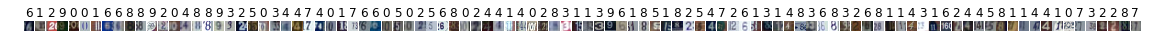

In [10]:
"""samples from test set"""
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

def getNumber(oneHotEncoding):
    for i,j in enumerate(oneHotEncoding):
        if j == 1:
            return i
    return 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=100)

im_samples = []
  
#plt.imshow(np.abs(train_imgData[:,:,:,34]))

for i, j in enumerate(np.sort(np.random.randint(0, test_labelT.shape[0], size=100))):
    houseNum = getNumber(test_labelT[j,:])
    im_samples.extend([j])
#print (len(im_samples))
    ax[i].axis('off')
    ax[i].set_title(houseNum, loc='center')
    ax[i].imshow(np.abs(test_imgData[:,:,:,j]))

In [11]:
### NOTE : To change conv filter numbers, look into depth1 and depth2 in both layer1_weights and layer1_biases
graph = tf.Graph()
with graph.as_default():

    def createTestGraphPlaceHoldersAndWeights(graph):
        print  ("createTestGraph called ...")
        #print (tf.get_variable_scope())
        #tf.get_variable_scope().reuse_variables()
        """
        Constructing the placeholders and variables in the TensorFlow Graph
        """
        #Training Dataset
        tf_test_data = tf.placeholder(tf.float32, shape=(len(im_samples), width, height, channels))
        """
        Create the variables
        """
        with tf.variable_scope("graph", reuse=None):        
            # Layer 1: (5, 5, 3, 16)
            try:
                layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, channels, depth1],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]))
                # Layer 2: (5, 5, 16, 32)
                layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))

                # Layer 2: (3, 3, 32, 64)
                layer21_weights = tf.get_variable("W21", shape=[3, 3, 32, 64],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer21_biases = tf.Variable(tf.constant(1.0, shape=[64]))

                # Layer 3: (2304, 128)
                layer3_weights = tf.get_variable("W3",shape=[8*8*64, hidden],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden]))
                print (layer3_weights.get_shape())
                #   Layer 4: (128, 10)
                layer4_weights = tf.get_variable("W4",shape=[hidden, n_labels],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer4_biases = tf.Variable(tf.constant(1.0, shape=[n_labels]))

                dropout = tf.placeholder(tf.float32)
                
            except ValueError:
                tf.get_variable_scope().reuse_variables()
                layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, channels, depth1],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]))
                # Layer 2: (5, 5, 16, 32)
                layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))

                # Layer 2: (3, 3, 32, 64)
                layer21_weights = tf.get_variable("W21", shape=[3, 3, 32, 64],\
                       initializer=tf.contrib.layers.xavier_initializer_conv2d())    
                layer21_biases = tf.Variable(tf.constant(1.0, shape=[64]))

                # Layer 3: (2304, 128)
                layer3_weights = tf.get_variable("W3",shape=[8*8*64, hidden],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden]))
                print (layer3_weights.get_shape())
                #   Layer 4: (128, 10)
                layer4_weights = tf.get_variable("W4",shape=[hidden, n_labels],\
                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
                layer4_biases = tf.Variable(tf.constant(1.0, shape=[n_labels]))

                dropout = tf.placeholder(tf.float32)

                # Layer 3: (1024, 128)
        #placeholders = (tf_train_dataset,tf_train_labels,tf_test_dataset,tf_extra_dataset)
        placeholders = tf_test_data
        layersWt     = (layer1_weights,layer2_weights,layer21_weights,layer3_weights,layer4_weights)
        layersBias   = (layer1_biases,layer2_biases,layer21_biases,layer3_biases,layer4_biases)
        return placeholders,layersWt,layersBias

    def createModelTest(data,keep_prob):
        # Conv 1 and RELU : output dim 32*32*16
        conv   = tf.nn.conv2d(data,layersWt[0], [1,1,1,1],padding='SAME', name='C1')
        hidden = tf.nn.relu(conv + layersBias[0])    
        lrn    = tf.nn.local_response_normalization(hidden)
        # Max pool 1 : output dim 16*16*16
        sub    = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')

        # Conv 2 and RELU : output dim 
        conv2  = tf.nn.conv2d(sub, layersWt[1], [1,1,1,1], padding='SAME', name='C3')
        hidden = tf.nn.relu(conv2 + layersBias[1])
        lrn    = tf.nn.local_response_normalization(hidden)
        # Max pool 1 : output dim 16*16*16
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')

        conv   = tf.nn.conv2d(sub, layersWt[2], [1,1,1,1], padding='SAME', name='C3')
        hidden = tf.nn.relu(conv + layersBias[2])
        
        shape  = hidden.get_shape().as_list()
        #lrn    = tf.nn.local_response_normalization(hidden)
        #sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,1,1,1], 'SAME', name='S2')
        
        # sub dimensions are 8*8*16
        #shape = sub.get_shape().as_list()
        #print (sub.get_shape())
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # reshape [:,2304]
        # reshape is flattended vectors of 1024 length
        # create the fully connected layer
        fullyConnectedLayer = tf.matmul(reshape,layersWt[3]) + layersBias[3]
        hidden  = tf.nn.relu(fullyConnectedLayer)
        # hidden dimension is Y * 128
        #   Dropout
        dropout_layer = tf.nn.dropout(hidden, keep_prob)
        # output is Y * 10
        classifierLayer = tf.matmul(dropout_layer, layersWt[4]) + layersBias[4]
        return classifierLayer
        
    print ("Graph created")

Graph created


In [12]:
with graph.as_default():
    placeholders,layersWt,layersBias = createTestGraphPlaceHoldersAndWeights(graph)
    tf_test_dataset = placeholders
    
    logits = createModelTest(tf_test_dataset,0.93)
    test_prediction = tf.nn.softmax(logits)
    print (test_prediction.get_shape())
    #test_prediction = tf.transpose(tf.argmax(test_prediction, 2))
    print ("Model created")
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as session:
    saver.restore(session, "trained_NN_30K_7Layer//CNN_multi.ckpt")
    print("Model restored.")  

    print('Initialized')
#     print ("test_imgData shape",test_imgT.shape,im_samples)
    
    test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_imgT[im_samples,:,:,:],})

createTestGraph called ...
(4096, 128)
(100, 10)
Model created
Model restored.
Initialized


Now lets plot the images and see what the prediction actually looks like

 accurate prediction = 84


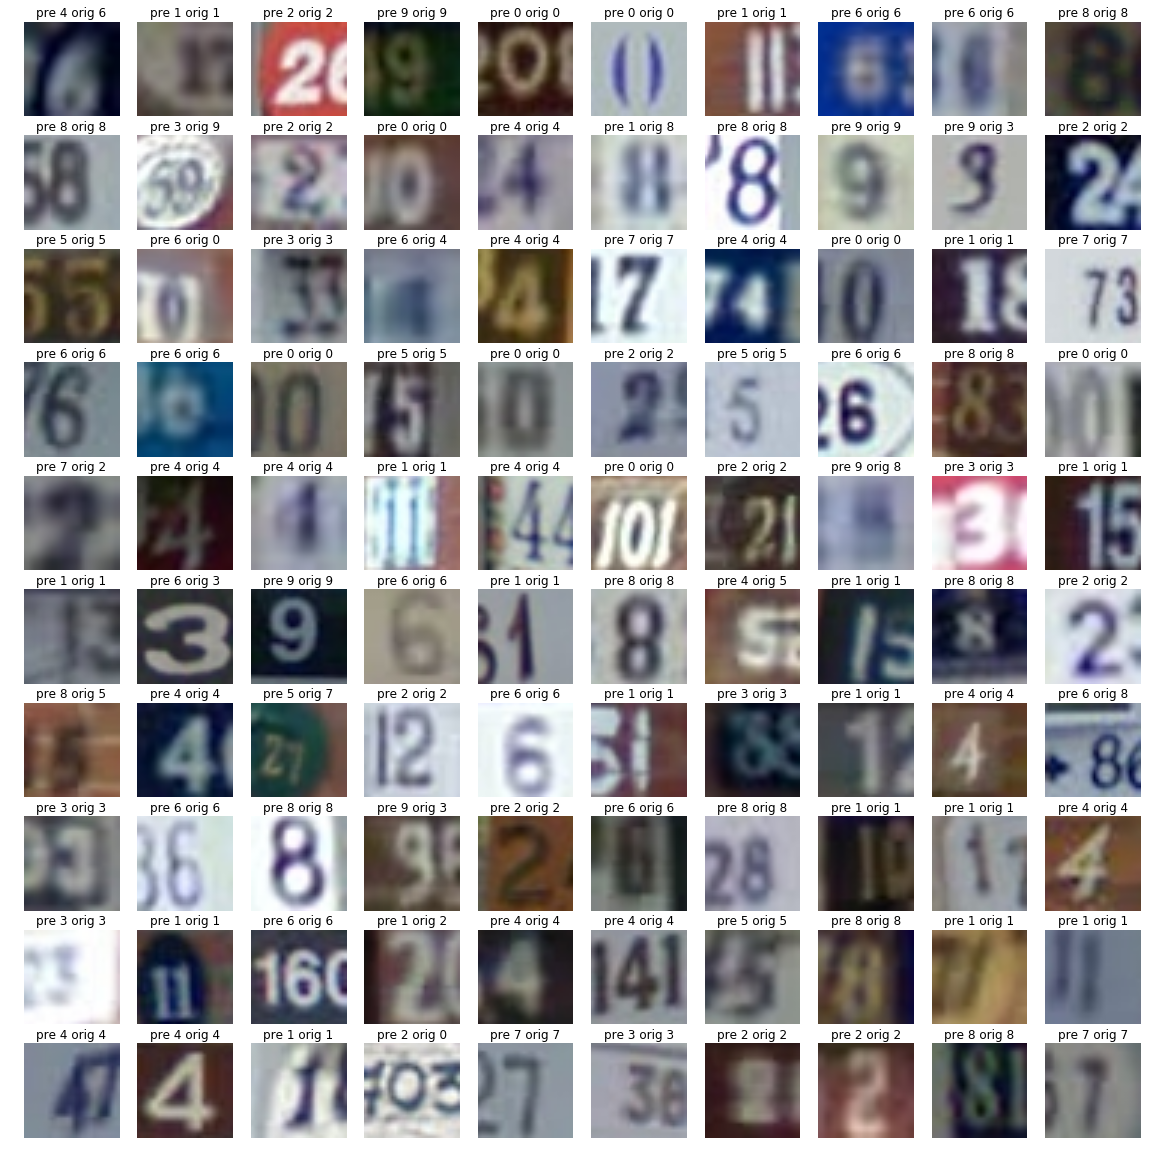

In [13]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=10, ncols=10)
numRows = 2
numCols = 10
# print (ax)
accuracy = 0
itemId   = 0
rowNum   = 0
for i, j in enumerate(im_samples):
    houseNum = np.argmax(test_prediction[i])
    #print ("house Num",houseNum)
    img = test_imgData[:,:,:,j]
    
    if houseNum == getNumber(test_labelT[j,:]):
        accuracy += 1
    if i % 10 == 0 and i >0:
        rowNum += 1
        itemId = 0
    try:
        ax[rowNum,itemId].axis('off')
        ax[rowNum,itemId].set_title("pre {} orig {}".format(houseNum,getNumber(test_labelT[j,:])), loc='center')
        ax[rowNum,itemId].imshow(np.abs(img))
        itemId += 1
    except Exception, e:
        print (" i",i)

print (" accurate prediction =",accuracy)